# Optiver Trading At The Close

[Competition](https://www.kaggle.com/competitions/optiver-trading-at-the-close)

[GitHub Repository](https://github.com/cvaisnor/DNN-Final-Project)

[Google Slides Presentation](https://docs.google.com/presentation/d/1Xc5F1_NveFi1il3GqHej2aqVmklR_jZU4kx6ZJhiDEM/edit?usp=sharing)

# General Imports

In [1]:
import os
import numpy as np
import pandas as pd
import importlib

import helpers

from helpers.common import load_data, plot_predictions, submit_dummy_predictions
from helpers.pipeline import LogFeatures, LagFeatures, RollingMeanFeatures, DiffFeatures, ExpandingMeanFeatures, \
ForwardFillValues, FillZero, DataFrameWrapper, PolynomialFeaturesWrapper, MissingValueImputer

kaggle_environment = False # True if running on Kaggle, don't forget to add the dataset!
if not kaggle_environment:
    # Reload the modules
    importlib.reload(helpers.common)
    importlib.reload(helpers.pipeline)


# Loading Data

In [2]:
original_train, test, revealed_targets, sample_submission = load_data(kaggle_environment)

In [90]:
split_ratio = 0.8  # 80% for training, 20% for testing
split_idx = int(len(original_train) * split_ratio)

train = original_train.iloc[:split_idx]
test = original_train.iloc[split_idx:]

train = train.dropna(subset=['target'])
test = test.dropna(subset=['target'])

# train = train.dropna()
# test = test.dropna()

y = train['target'].values
y_test = test['target'].values

In [91]:
print(train.shape)
print(test.shape)

(4190352, 17)
(1047540, 17)


In [92]:
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,1.338028e+07,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,1.838975e+07,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,1.786061e+07,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190379,199,385,410,3537409.33,-1,0.998412,2.221740e+07,0.956005,0.965531,0.998412,18681.75,0.998720,73092.50,0.998475,4.849434,21216,385_410_199
4190380,0,385,420,3900741.71,1,1.000651,3.660036e+07,1.037392,1.013793,1.000459,10429.00,1.000747,4485.76,1.000660,1.660585,21217,385_420_0
4190381,1,385,420,688073.24,1,1.003555,7.819417e+06,1.024143,1.009245,1.002968,13850.19,1.003614,3593.10,1.003481,-0.849962,21217,385_420_1
4190382,2,385,420,1839236.34,1,1.001819,7.746652e+06,1.129382,1.023235,1.001407,37065.46,1.002077,13399.11,1.001899,2.019405,21217,385_420_2


# Feature Engineering Section

In [93]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Column Preprocessor
columns_to_keep = [
    'imbalance_size_log', 'matched_size_log', #'stock_id',
    'imbalance_buy_sell_flag', 'reference_price',
    'far_price', 'near_price', 'bid_price', 'bid_size_log', 'ask_price', 'ask_size_log', 'wap_log', 'wap_log_lag_1',
    #'wap_log_lag_5', # 'wap_lag10', 'wap_lag15', 'wap_lag20',
    'wap_log_rolling_mean2', #'wap_log_rolling_mean3', #'wap_log_rolling_mean5',
    'wap_log_diff', 'wap_log_expanding_mean', 'seconds_in_bucket',
    'matched_size_lag_1', 'matched_size_lag_3'
]

one_hot_cols = []
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), one_hot_cols),
        ('passthrough', 'passthrough', columns_to_keep)
    ],
    remainder='drop'  # Drop other columns
)

# Main Pipeline
pipeline = Pipeline([
    ('logs', LogFeatures(['imbalance_size', 'matched_size', 'wap', 'bid_size', 'ask_size'])),
    ('wap_lags', LagFeatures(['wap_log'], [1, 5])),
    ('matched_size_lags', LagFeatures(['matched_size'], [1, 3, 5])),
    ('wap_rolling_means', RollingMeanFeatures(['wap_log'], [2, 3, 5])),
    ('wap_diff', DiffFeatures(['wap_log'])),
    ('wap_expanding_mean', ExpandingMeanFeatures(['wap_log'])),
    ('missing_value_imputer', MissingValueImputer(['far_price', 'near_price'])),
    ('forward_fill', ForwardFillValues()),
    ('fill_zero', FillZero()),
    ('preprocessor', DataFrameWrapper(preprocessor, columns_to_keep)),
    # ('scaler', DataFrameWrapper(StandardScaler())),
    # ('poly', PolynomialFeaturesWrapper(2)),
])

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
    train_transformed = pipeline.fit_transform(train)
    test_transformed = pipeline.transform(test)

/Users/cdurbin/JHU/DeepNeuralNetworks/DNN-Final-Project/helpers/pipeline.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X[column] = X.groupby('stock_id')[column].transform(lambda group: group.fillna(method='ffill'))
/Users/cdurbin/JHU/DeepNeuralNetworks/DNN-Final-Project/helpers/pipeline.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X[column] = X.groupby('stock_id')[column].transform(lambda group: group.fillna(method='ffill'))


CPU times: user 27.7 s, sys: 11.2 s, total: 38.9 s
Wall time: 28.5 s


In [94]:
X = train_transformed
X_test = test_transformed

In [95]:
X

,seconds_in_bucket,imbalance_buy_sell_flag,reference_price,far_price,near_price,bid_price,ask_price,imbalance_size_log,matched_size_log,wap_log,bid_size_log,ask_size_log,wap_log_lag_1,matched_size_lag_1,matched_size_lag_3,wap_log_rolling_mean2,wap_log_diff,wap_log_expanding_mean
0,14.972582,16.409292,1.0,0.999812,1.002549,0.999809,0.999812,11.012916,1.000026,9.047119,0.693147,0.000000,0.000000,0.000000,0.693147,0.0,0.000000e+00,0.000000e+00
1,12.023380,14.311557,-1.0,0.999896,1.002549,0.999809,0.999896,8.081487,1.000660,9.933342,0.693147,0.000000,0.000000,0.000000,0.693147,0.0,0.000000e+00,0.000000e+00
2,12.621095,14.414000,-1.0,0.999561,1.002549,0.999809,0.999403,10.544209,1.000298,9.851984,0.693147,0.000000,0.000000,0.000000,0.693147,0.0,0.000000e+00,0.000000e+00
3,16.293534,16.727304,-1.0,1.000171,1.002549,0.999809,0.999999,7.751862,1.000214,13.079526,0.693147,0.000000,0.000000,0.000000,0.693147,0.0,0.000000e+00,0.000000e+00
4,13.011546,16.698109,-1.0,0.999532,1.002549,0.999809,0.999394,9.710300,1.000016,6.075576,0.693147,0.000000,0.000000,0.000000,0.693147,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190347,15.078905,16.916386,-1.0,0.998412,0.956005,0.965531,0.998412,9.835356,0.998720,11.199495,0.692384,0.692567,0.692475,-0.000182,0.693203,410.0,2.221398e+07,2.209742e+07
4190348,15.176678,17.415569,1.0,1.000651,1.037392,1.013793,1.000459,9.252442,1.000747,8.408886,0.693477,0.693539,0.693508,-0.000061,0.693065,420.0,3.662048e+07,3.644900e+07
4190349,13.441652,15.872121,1.0,1.003555,1.024143,1.009245,1.002968,9.536126,1.003614,8.187049,0.694886,0.694609,0.694747,0.000278,0.693134,420.0,7.819417e+06,7.821633e+06
4190350,14.424862,15.862771,1.0,1.001819,1.129382,1.023235,1.001407,10.520468,1.002077,9.503018,0.694096,0.694251,0.694174,-0.000155,0.693208,420.0,7.688516e+06,7.669137e+06


In [96]:
# X['wap_lag_1']
# X[seconds_in_bucket]

All feature transformations should be combined into a generate_feature() function. This can then be applied to the test data will in the for loop for the Optiver API.

In [97]:
def generate_features(cumulative_test_df, current_test, pipeline):
    transformed_df = pipeline.transform(cumulative_test_df)
    
    # Only return rows corresponding to the current test dataframe
    return transformed_df.iloc[-len(current_test):]


# Slicing

Generally, don't change the cell below. It is used to slice the data into training and validation sets.

In [98]:
# imports
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X
y_train = y 

# Model Development

In [99]:
%%time
import lightgbm as lgb


# lgbm = lgb.LGBMRegressor(n_jobs=-1, random_state=0, force_col_wise=True,
#                          verbose=-1, boosting_type='gbdt', num_leaves=10,
#                          reg_alpha=0, reg_lambda=0.2, objective='regression_l1')

lgbm = lgb.LGBMRegressor(n_jobs=-1, random_state=0, objective='regression_l1')
lgbm.fit(X_train, y_train)
# lgbm.fit(X_train.drop(columns=['row_id', 'time_id', 'target']), y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4138
[LightGBM] [Info] Number of data points in the train set: 4190352, number of used features: 18
[LightGBM] [Info] Start training from score -0.069737
CPU times: user 1min 20s, sys: 5.45 s, total: 1min 26s
Wall time: 10.2 s


LGBMRegressor(n_jobs=-1, objective='regression_l1', random_state=0)

In [100]:
# # Check for NaNs in y_test
# nan_in_y_test = np.isnan(y_test).any()
# print(f"NaN in y_test: {nan_in_y_test}")

# # Check for NaNs in predictions
# nan_in_predictions = np.isnan(predictions).any()
# print(f"NaN in predictions: {nan_in_predictions}")

In [101]:
# lgbm.score(X_test, y_test)

from sklearn.metrics import mean_absolute_error

# predictions = lgbm.predict(X_test.drop(columns=['row_id', 'time_id', 'target']))
predictions = lgbm.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error on the test set: {mae:.4f}")
# predictions2 = lgbm.predict(X_train.drop(columns=['row_id', 'time_id', 'target']))
predictions2 = lgbm.predict(X_train)
mae2 = mean_absolute_error(y_train, predictions2)
print(f"Mean Absolute Error on the training set: {mae2:.4f}")

Mean Absolute Error on the test set: 5.9813
Mean Absolute Error on the training set: 6.3698


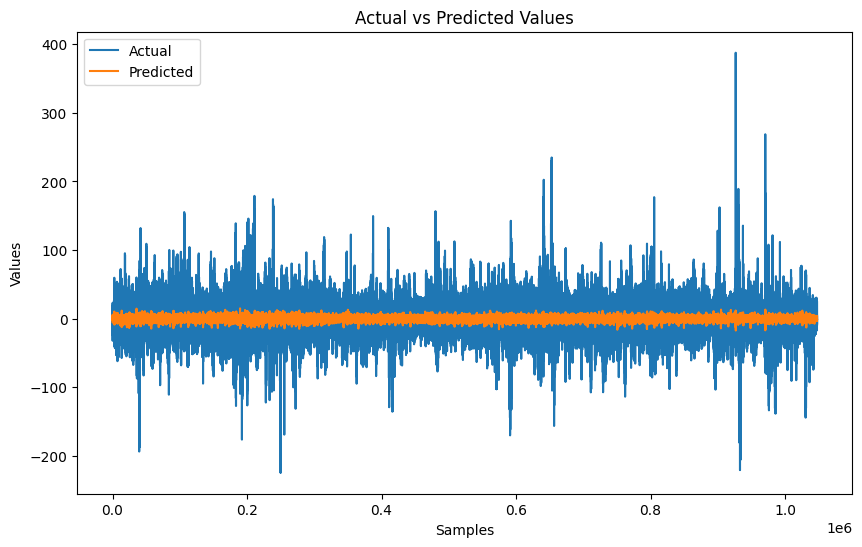

In [102]:
plot_predictions(y_test, predictions)

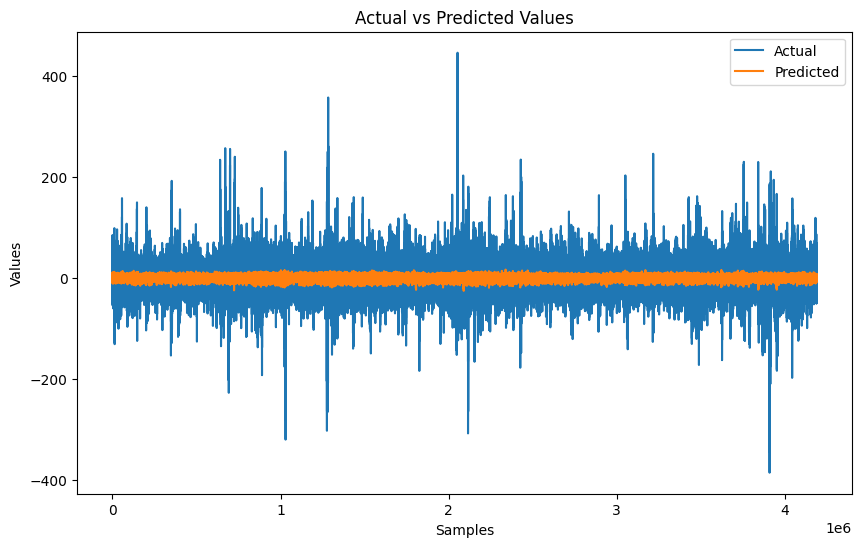

In [103]:
plot_predictions(y_train, predictions2)

In [104]:
print(predictions.min(), predictions.max())

-17.319437429001432 14.996849541656283


In [79]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [80]:
print('PyTorch Version: ', torch.__version__)
print('CUDA Available: ', torch.cuda.is_available())
if torch.cuda.is_available():
    print('Device Type: ', torch.cuda.get_device_name(0))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

PyTorch Version:  2.1.0
CUDA Available:  False


In [81]:
# convert to numpy arrays
# X_train = X_train.values
# X_test = X_test.values

In [82]:
class PyTorchMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PyTorchMLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size


        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, hidden_size)  # Output is a single floating point number
        self.fc4 = nn.Linear(self.hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def fit(self, X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate, device, verbose=True):
        self.to(device)
        self.train()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.L1Loss()
        X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
        y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device)
        X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
        y_test_t = torch.tensor(y_test, dtype=torch.float32, device=device)
        for epoch in tqdm(range(epochs), desc='Epochs'):
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train_t[i:i+batch_size]
                batch_y = y_train_t[i:i+batch_size]
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss = criterion(outputs, batch_y.view_as(outputs))
                loss.backward()
                optimizer.step()
            self.eval()
            with torch.no_grad():
                y_pred = self(X_test_t)
                test_loss = criterion(y_pred, y_test_t.view_as(y_pred))
                if verbose:
                    print(f'Epoch: {epoch+1}/{epochs}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')
            self.train()

    def predict(self, X_test, device):
        self.to(device)
        self.eval()
        with torch.no_grad():
            X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
            y_pred = self(X_test_t)
        return y_pred.cpu().numpy()

In [83]:
model = lgbm

In [84]:
# # Uncomment to use NN as the model instead
# # convert to numpy arrays
# X_train = X_train.values
# X_test = X_test.values
# # creating the model and fitting it on the data from the original sklearn train test split
# model = PyTorchMLP(input_size=X_train.shape[1], hidden_size=128)
# model.fit(X_train, y_train, X_test, y_test, epochs=2, batch_size=256, learning_rate=0.001, device=device)

# Generating Predictions

Only for Kaggle:
When uploading notebook, make sure to add the Optiver data on the right side of the screen.

In [85]:
if kaggle_environment:
    import optiver2023
    env = optiver2023.make_env()
    iter_test = env.iter_test()

In [86]:
# Uncomment this cell to try to get unstuck from having to restart and run the whole notebook again
# submit_dummy_predictions(env, sample_prediction)

In [87]:
if kaggle_environment:
    # To count how many time the "for loop" runs.
    counter = 0

    # init 3 empty lists
    test_ls, revealed_targets_ls, sample_prediction_ls = [], [], []
    cumulative_test_df = pd.DataFrame()

    for (test_in, revealed_targets, sample_prediction) in iter_test:
        # Append the dataframe that API return into the list.
        test_ls.append(test_in.copy())
        revealed_targets_ls.append(revealed_targets.copy())
        sample_prediction_ls.append(sample_prediction.copy())

        cumulative_test_df = pd.concat([cumulative_test_df, test_in], axis=0, ignore_index=True)

        # Generate features
        test_transformed = generate_features(cumulative_test_df, test_in, pipeline)

        # Writes our predictions 
        sample_prediction["target"] = model.predict(test_transformed)
        
        # This line submit our predictions.
        env.predict(sample_prediction)
        counter += 1

    print('\n', '=' * 50, sep="")
    print(f"counter: {counter}")

In [88]:
# cumulative_test_df.to_csv('file.csv')

In [89]:
y_test.var()

81.03471690678968